In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import cv2
from PIL import Image

from torch.optim import AdamW

import matplotlib.pyplot as plt
import seaborn as sns


import os
import random
import functools


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
proj_path = '.'
data_path = f'{proj_path}/MURA-v1.1'

# Load Dataset

In [5]:
# ALL Data
X_train = pd.read_csv('./MURA-v1.1/train_image_paths.csv', header=None, names=['filePath'])
y_train = pd.read_csv('./MURA-v1.1/train_labeled_studies.csv', names=['patientDir', 'label'])

X_test = pd.read_csv('./MURA-v1.1/valid_image_paths.csv', header=None, names=['filePath'])
y_test = pd.read_csv('./MURA-v1.1/valid_labeled_studies.csv', names=['patientDir', 'label'])

In [8]:
X_train.shape

(36808, 1)

In [9]:
X_train.head()

,filePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [10]:
X_train[:3]

,filePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...


The label is for a patient. (for all is XRays)

In [11]:
y_train.iloc[0, 0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/'

In [12]:
y_train.iloc[:, 0]


0        MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1        MURA-v1.1/train/XR_SHOULDER/patient00002/study...
2        MURA-v1.1/train/XR_SHOULDER/patient00003/study...
3        MURA-v1.1/train/XR_SHOULDER/patient00004/study...
4        MURA-v1.1/train/XR_SHOULDER/patient00005/study...
                               ...                        
13452    MURA-v1.1/train/XR_HAND/patient11180/study1_ne...
13453    MURA-v1.1/train/XR_HAND/patient11181/study1_ne...
13454    MURA-v1.1/train/XR_HAND/patient11182/study1_ne...
13455    MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
13456    MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
Name: patientDir, Length: 13457, dtype: object

# Dataset description

In [6]:
print(f"# of patients: {y_train.shape[0]}")
print(f"# samples/ X-rays: {X_train.shape[0]}")
print()

labels, counts = np.unique(y_train['label'], return_counts=True)
print(f"# labels: {len(labels)}")
print(f"Non-fraction: {labels[0]}; Fraction Label: {labels[1]}")
print()

print(f"# patient with fraction: {counts[1]}")
print(f"# patient withOUT fraction: {counts[0]}")
print()

print(f"Proposion of positive (patients with fraction): {counts[1] / y_train.shape[0]:.3f}")


# of patients: 13457
# samples/ X-rays: 36808

# labels: 2
Non-fraction: 0; Fraction Label: 1

# patient with fraction: 5177
# patient withOUT fraction: 8280

Proposion of positive (patients with fraction): 0.385


In [15]:
np.unique(y_train['label'], return_counts=True)

(array([0, 1]), array([8280, 5177]))

In [7]:
def show_xr(xr_path):
    xr = cv2.imread(xr_path)
    plt.imshow(xr)
    plt.show()

def show_patient_images(patient_dir):
    xrs = os.listdir(patient_dir)

    for xr in xrs:
        print(xr)
        show_xr(f'{patient_dir}/{xr}')

#### Patient 1

image1.png


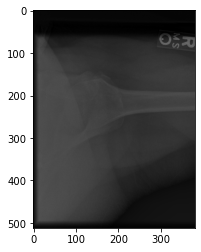

image2.png


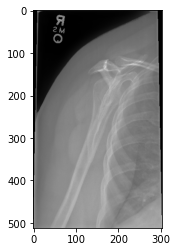

image3.png


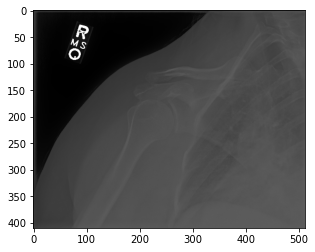

In [122]:
show_patient_images(y_train['patientDir'][0])

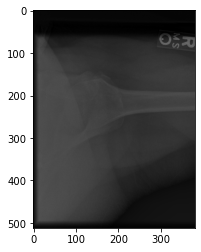

In [124]:
show_xr(X_train['filePath'][0])

In [105]:
def get_client_data(patient_path: str):
    res = []
    xr_names = os.listdir(patient_path)

    for xr in xr_names:
        xr_data = cv2.imread(f'{patient_path}/{xr}')
        res.append(xr_data)

    return res

# Preparation

In [17]:
type(X_train)

pandas.core.frame.DataFrame

In [8]:
X_train['Label'] = X_train.apply(lambda x:1 if 'positive' in x.filePath else 0, axis=1)
X_train['BodyPart'] = X_train.apply(lambda x: x.filePath.split('/')[2][3:],axis=1)
X_train['StudyType'] = X_train.apply(lambda x: x.filePath.split('/')[4][:6],axis=1)

X_test['Label'] = X_test.apply(lambda x:1 if 'positive' in x.filePath else 0, axis=1)
X_test['BodyPart'] = X_test.apply(lambda x: x.filePath.split('/')[2][3:],axis=1)
X_test['StudyType'] = X_test.apply(lambda x: x.filePath.split('/')[4][:6],axis=1)

X_train.set_index(["filePath", "BodyPart"]).count(level="BodyPart")
X_train.set_index(["filePath", "Label"]).count(level="Label")

,BodyPart,StudyType
Label,,
0,21935,21935
1,14873,14873


In [9]:
X_train.head()

,filePath,Label,BodyPart,StudyType
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1


# Focus on Shoulder, Hand and Elbow

In [14]:
focused_body_parts = ['ELBOW', 'SHOULDER', 'HAND']

X_train_focused = X_train[X_train['BodyPart'].isin(focused_body_parts)]
X_test_focused = X_test[X_test['BodyPart'].isin(focused_body_parts)]

In [15]:
X_train_focused.set_index(["filePath", "BodyPart"]).count(level="BodyPart")
X_train_focused.set_index(["filePath", "Label"]).count(level="Label")

,BodyPart,StudyType
Label,,
0,11195,11195
1,7658,7658


In [16]:
print(X_train.shape)
print(X_train_focused.shape)

(36808, 4)
(18853, 4)


In [17]:
print(X_test.shape)
print(X_test_focused.shape)

(3197, 4)
(1488, 4)


# Distribution

In [138]:
np.unique(X_train['BodyPart'], return_counts=True)

(array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER',
        'WRIST'], dtype=object),
 array([4931, 5106, 1825, 5543, 1272, 8379, 9752]))

Train data:


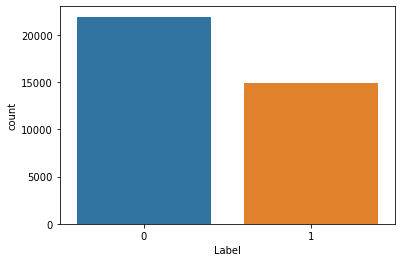

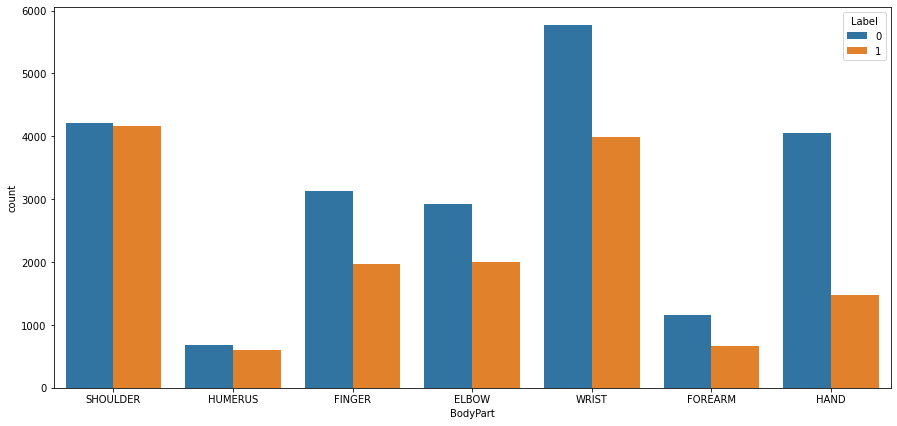

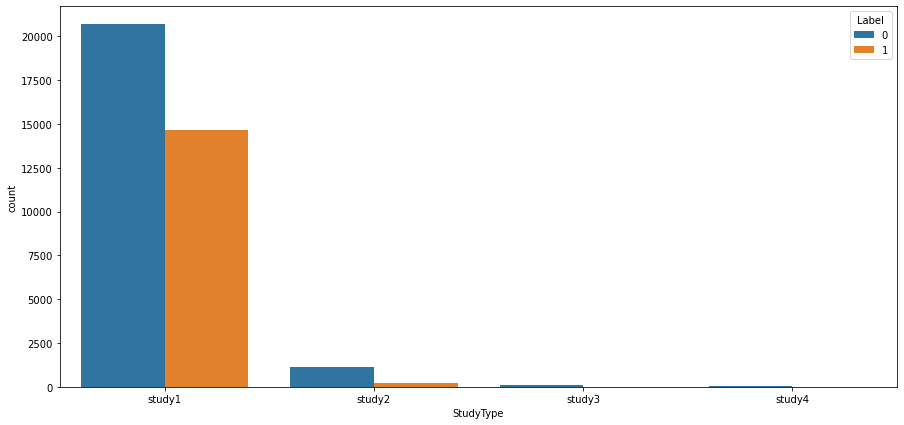

In [147]:
# Train
print('Train data:')
sns.countplot(X_train['Label'])
plt.figure(figsize=(15,7))
sns.countplot(data=X_train,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
_ = sns.countplot(data=X_train,x='StudyType',hue='Label')

Validation Data:


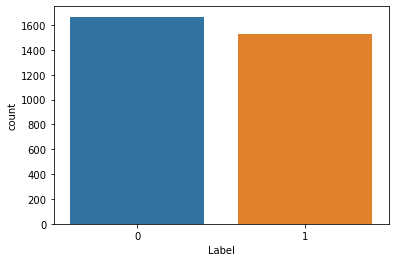

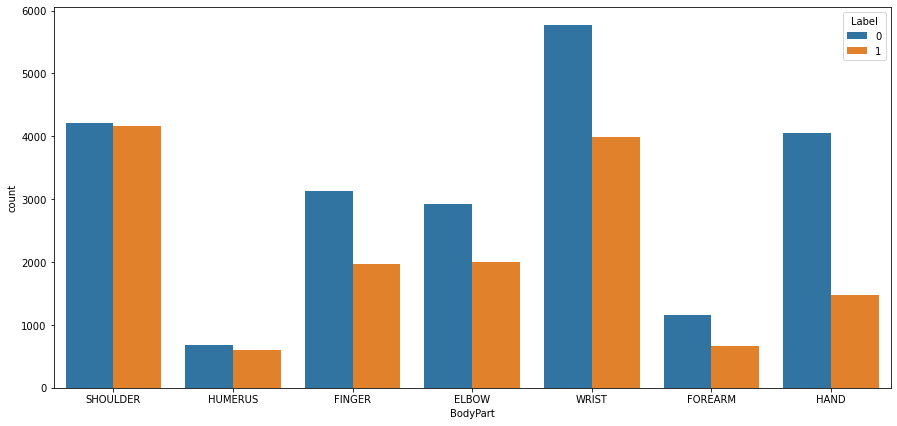

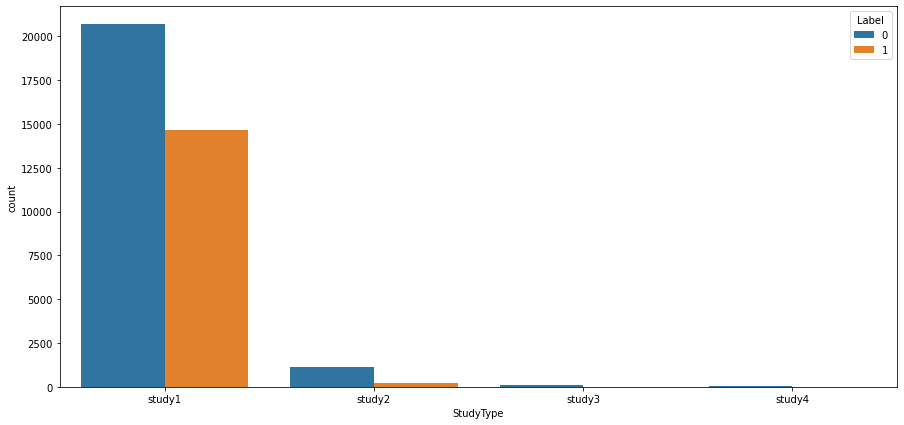

In [148]:
# Test
print('Validation Data:')
sns.countplot(X_test['Label'])
plt.figure(figsize=(15,7))
sns.countplot(data=X_train,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
_ = sns.countplot(data=X_train,x='StudyType',hue='Label')

# Dataset

In [18]:
height, width = 224, 224
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((height, width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.CenterCrop((height, width)),
    transforms.Resize((height, width)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

In [19]:
class SimCLRAugmentedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        img_name=self.dataset.iloc[idx,0]
        img = Image.open(img_name)

        label=self.dataset.iloc[idx,1]

        img1 = self.transform(img)
        img2 = self.transform(img)
        label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)

        return img1, img2, label

In [20]:
def nt_xent_loss(features1, features2, temperature):
    """
    Implements the NT-Xent (Normalized Temperature-Scaled Cross Entropy Loss)
    Args:
        features_i, features_j: the features from the last layer of the neural network for two augmented versions of the same image.
        temperature: temperature scaling parameter.
        device: the device on which tensors should be allocated.
    Returns:
        The NT-Xent Loss.
    """
    batch_size = features1.shape[0]

    # normalize the input features
    features1 = F.normalize(features1, dim=1)
    features2 = F.normalize(features2, dim=1)

    # Concatenate the features from both views
    features = torch.cat([features1, features2], dim=0)

    # Compute similarity matrix
    similarity_matrix = torch.mm(features, features.T)
    # Scale the similarity_matrix by temperature
    similarity_matrix /= temperature

    # Create target matrix
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)

    # positives are the similarity scores on the diagonal
    positives = similarity_matrix[mask].view(2 * batch_size, 1)
    # negatives are the similarity scores off the diagonal
    negatives = similarity_matrix[~mask].view(2 * batch_size, batch_size * 2 - 1)

    # Concatenate and calculate cross entropy loss
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=device)
    loss = F.cross_entropy(logits, labels)
    
    return loss


In [24]:
from tqdm import tqdm

In [30]:
class SimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()
        
        # Use the ResNet model except the last layer (fc)
        self.f = nn.Sequential(*list(resnet50(pretrained=False).children())[:-1])
        
        # Projection head
        self.g = nn.Sequential(
            nn.Linear(2048, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, feature_dim, bias=True)
        )

        # Define Optimizer - combine the parameters of the two parts of the model
        parameters = list(self.f.parameters()) + list(self.g.parameters())
        self.optimizer = AdamW(parameters, lr=0.001, weight_decay=0.01)

        self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.f(x)
        representation = torch.flatten(x, start_dim=1)
        out = self.g(representation)
        return out, representation

    def criterion(self, feat1, feat2, temperature):
        return nt_xent_loss(feat1, feat2, temperature)
    
    def train_loop(self, train_dataloader, num_epochs):
        loss_lst = []
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            for images1, images2, labels in train_dataloader:
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
                self.optimizer.zero_grad()
                feature1, representation1 = self.forward(images1)
                feature2, representation2= self.forward(images2)

                # Calculate the loss
                loss = self.criterion(feature1, feature2, temperature=0.08)
                running_loss += loss.item()
                # Back-propagation and optimization
                loss.backward()
                self.optimizer.step()
                
            epoch_loss = running_loss / len(train_dataloader)
            loss_lst.append(epoch_loss)
            print(f"Epoch {epoch+1} - Loss: {epoch_loss}")


        return loss_lst


In [34]:
# Create the augmented dataset
train_set = SimCLRAugmentedDataset(X_train_focused, transform_train)
train_dataloader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)

# Similarly for test data
test_set = SimCLRAugmentedDataset(X_test_focused, transform_test)
test_dataloader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)

In [35]:
len(train_dataloader)

295

In [36]:
# choose number of epoches (they used 60)
num_epochs_lst = [2, 4]
model_losses_lst = []

for num_epochs in num_epochs_lst:
    model = SimCLR().to(device)
    hist_losses = model.train_loop(train_dataloader, num_epochs)
    model_losses_lst.append(hist_losses)
    torch.save(model.state_dict(), './pretrained-simclr-models/model_{num_epochs}e')

 50%|██████████████████████                      | 1/2 [05:46<05:46, 346.77s/it]

Epoch 1 - Loss: 0.06102524860604208


100%|████████████████████████████████████████████| 2/2 [11:30<00:00, 345.36s/it]

Epoch 2 - Loss: 0.004472360118308057



 25%|███████████                                 | 1/4 [05:49<17:28, 349.63s/it]

Epoch 1 - Loss: 0.0723286542110145


 50%|██████████████████████                      | 2/4 [11:40<11:40, 350.25s/it]

Epoch 2 - Loss: 0.005680867529995108


 75%|█████████████████████████████████           | 3/4 [17:30<05:50, 350.04s/it]

Epoch 3 - Loss: 0.0030201791927723562


100%|████████████████████████████████████████████| 4/4 [23:20<00:00, 350.08s/it]

Epoch 4 - Loss: 0.0023262461319849903


In [39]:
model_losses_lst = [[0.061, 0.00447], [0.072, 0.00568, 0.00302, 0.002326]]

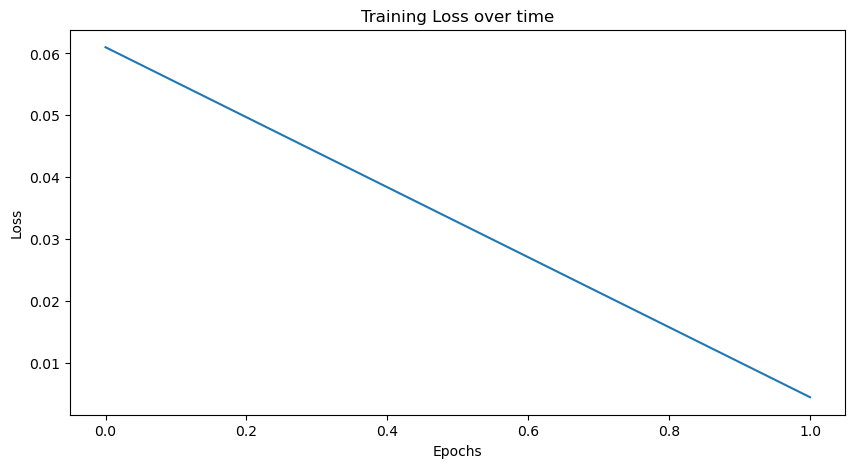

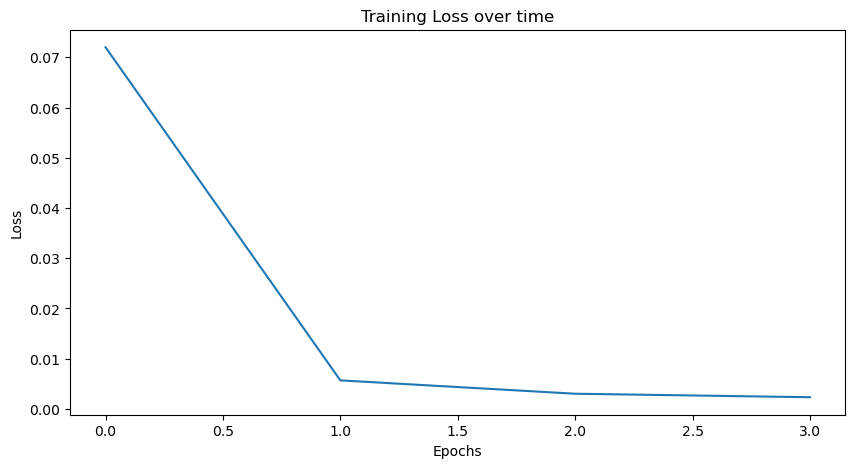

In [40]:
for losses in model_losses_lst:
    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss over time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Fine tuning

In [ ]:
pretrained_model = SimCLR().to(device)
pretrained_model = model.load_state_dict(torch.load('path_to_save_your_model.pth'))
model_encoder = pretrained_model.f 

# or use the all model but takes the encoder part.
# but then, there is an issue to back-propogate. 
# 
